# TP2 : Equation intégrale pour l’équation de Helmholtz 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import roots_legendre, jv, hankel1

%matplotlib inline
plt.rcParams['figure.dpi']= 100

### Maillage

In [2]:
def generate_nodes(N, a):
    """
    Génère les N noeuds sur le cercle de rayon a centré en 0.
    Retourne un tableau numpy de taille (N, 2).
    """
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)  # angles uniformes
    x = a * np.cos(angles)
    y = a * np.sin(angles)
    return angles, np.column_stack((x, y))

def generate_segments_indices(N):
    """
    Génère la liste des segments comme paires d’indices.
    Chaque noeud est relié au suivant (avec retour au premier).
    """
    return [(k, (k+1) % N) for k in range(N)]

### Fonctions exacts

In [3]:
def uInc(x,y,k):
    return np.exp(-1j*k*x)

def p(a,r,theta,k,ite=60):
    costheta = np.cos(theta)
    S = 0+0j
    for i in range(-ite,ite+1):
        Jn = jv(i,k*a)
        Hn = hankel1(i,k*a)
        Hnm = hankel1(i-1,k*r)
        Hnp = hankel1(i+1,k*r)
        const = (-1j)**i
        S += const * Jn * (Hnm-Hnp)*np.exp(-i*theta*1j)/Hn
    S *= k/2
    S += 1j * k * costheta * np.exp(-1j*k*r*costheta)
    return S

def uPlus(a,r,theta,k,ite=60):
    S = 0+0j
    for i in range(-ite,ite+1):
        Jn = jv(i,k*a)
        Hna = hankel1(i,k*a)
        Hnr = hankel1(i,k*r)
        S += (-1j)**i * Jn * Hnr * np.exp(-i*theta*1j)/Hna
    return -S

### Calcul d'intégrales avec Gauss-Legendre

In [4]:
def GaussLegendre(f,a,b,points,poids):
    n = len(points)
    x, w = points, poids
    S = 0.0
    for i in range(n):
        t = x[i]
        u = (b-a)/2*t + (b+a)/2
        S += w[i]*f(u)
    return (b-a)/2*S

def integrale2D(f,n1,n2,points,poids): 
    # n1,n2 points dans le plan aux extrémités du segment
    # f fonction à deux variables
    x1,y1 = n1[0],n1[1]
    x2,y2 = n2[0],n2[1]
    norm = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    def g(t):
        X = x1*(1-t)+x2*t
        Y = y1*(1-t)+y2*t
        return f(X,Y)*norm
    return GaussLegendre(g,0,1,points,poids)

### Calcul du second membre et de la matrice A

In [5]:
def G(n1,n2,k):
    x1,y1 = n1
    x2,y2 = n2
    z1 = x1 + 1j*y1
    z2 = x2 + 1j*y2
    return 1j*hankel1(0,k*np.abs(z2-z1))/4


def secondMembre(N,segments,nodes,uInc,points,poids):
    b = np.zeros(N,dtype=np.complex128)
    for e in segments:
        i = e[0]
        i2 = e[1]
        n1 = nodes[i]
        n2 = nodes[i2]
        b[i] = -integrale2D(lambda x,y:uInc(x,y,k),n1,n2,points,poids)
    return b

def matriceA(N,segments,nodes,G,points,poids):
    A = np.zeros((N,N),dtype=np.complex128)
    for ex in segments:
        i = ex[0]
        for ey in segments:
            j = ey[0]
            if i==j:
                coeff = -1/(2*np.pi)

                #partie singulière
                d = lambda x,y,j: np.sqrt((nodes[j][0]-x)**2 + (nodes[j][1]-y)**2)
                n1,n2 = nodes[(j+1)%N]
                long = d(n1,n2,j)
                f = lambda x,y: coeff*(d(x,y,(j+1)%N)*np.log(d(x,y,(j+1)%N)) + d(x,y,j)*np.log(d(x,y,j)) - long)
                A[i][j] += integrale2D(f,nodes[i],nodes[(i+1)%N],points,poids)

                #partie régulière
                const = 1j/4 + coeff*(np.log(k/2)+np.euler_gamma)
                g = lambda X,Y: integrale2D(lambda x,y: const,nodes[j],nodes[(j+1)%N],points,poids)
                A[i][j] += integrale2D(g,nodes[i],nodes[(i+1)%N],points,poids)
            else:
                I = lambda X,Y: integrale2D(lambda x,y: G((x,y),(X,Y),k),nodes[i],nodes[(i+1)%N],points,poids)
                A[i][j] += integrale2D(I,nodes[j],nodes[(j+1)%N],points,poids)
    return A

### Calcul de la représentation intégrale

In [6]:
def milieu(e,nodes):
    j = e[0]
    j2 = e[1]
    (x1,y1) = nodes[j]
    (x2,y2) = nodes [j2]
    return ((x1+x2)/2,(y1+y2)/2)

def representationIntegrale(q,N,points,poids,G,segments,nodes,a,k):
    l = len(q)
    M = np.zeros((l,N),dtype=np.complex128)
    A = matriceA(N,segments,nodes,G,points,poids)
    b = secondMembre(N,segments,nodes,uInc,points,poids)
    pNumerique = np.linalg.solve(A,b)
    for i in range(l): #calcul de la matrice contenant les intégrales
        n1 = q[i]
        for e in segments:
            j=e[0]
            j2=e[1]
            M[i][j] = integrale2D((lambda X,Y: G(n1,(X,Y),k)),nodes[j],nodes[j2],points,poids)
    U = np.matmul(M,pNumerique)
    return U

### Tracés

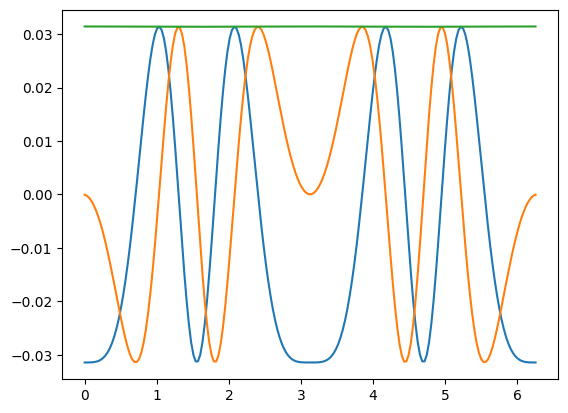

In [7]:
N = 200  # nombre de noeuds (par ex. 12)
Nxi = 100
a = 1.0  # rayon du cercle
k = 2*np.pi
n = 2 # nombre de terme dans la somme pour Gauss-Legendre

theta, nodes = generate_nodes(N, a)
segments = generate_segments_indices(N)


points, poids = np.polynomial.legendre.leggauss(n)

########### tracé de b en fonction de theta #############

b = secondMembre(N,segments,nodes,uInc,points,poids)

plt.figure()
plt.plot(theta,np.real(b))
plt.plot(theta,np.imag(b))
plt.plot(theta,np.abs(b))
plt.show()

In [8]:
N = 200  # nombre de noeuds (par ex. 12)
Nxi = 100
a = 1.0  # rayon du cercle
k = 2*np.pi
n = 2 # nombre de terme dans la somme pour Gauss-Legendre

theta, nodes = generate_nodes(N, a)
segments = generate_segments_indices(N)

########### calcul numérique de p #############

A = matriceA(N,segments,nodes,G,points,poids)
b = secondMembre(N,segments,nodes,uInc,points,poids)
pNumerique = np.linalg.solve(A,b) # normalement faut pas inverser la matrice, solveur itératif
pAnalytique = p(a,a,theta,k)

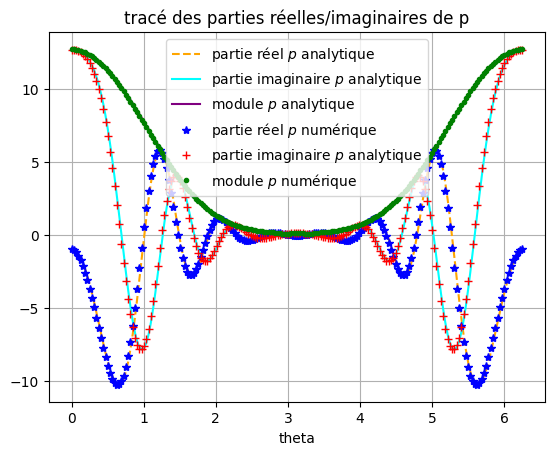

In [9]:
####### tracé de p sur le bord ########

plt.figure()
plt.plot(theta,np.real(pAnalytique),linestyle='--', color='orange', label='partie réel $p$ analytique')
plt.plot(theta,np.imag(pAnalytique),color='cyan',label='partie imaginaire $p$ analytique')
plt.plot(theta,np.abs(pAnalytique),color='purple',label='module $p$ analytique')
plt.plot(theta,np.real(pNumerique),marker='*',linestyle='None',color='blue',label='partie réel $p$ numérique')
plt.plot(theta,np.imag(pNumerique),marker='+',linestyle='None',color='red',label='partie imaginaire $p$ analytique')
plt.plot(theta,np.abs(pNumerique),marker='.',linestyle='None',color='green',label='module $p$ numérique')
plt.title("tracé des parties réelles/imaginaires de p")
plt.xlabel("theta")
plt.legend()
plt.grid()
plt.show()

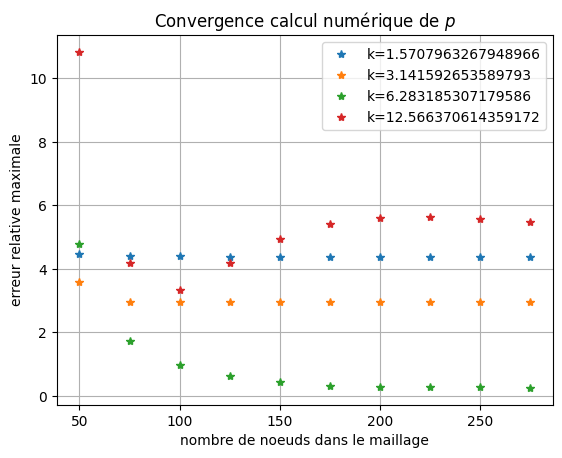

In [10]:
############# erreur relative pour p ##############

Nli = np.arange(50,300,25,dtype=int)

for kPara in [np.pi/2,np.pi,np.pi*2,np.pi*4]:
    e = []
    for n in Nli:
        angles, nodes = generate_nodes(n, a)
        segments = generate_segments_indices(n)
        A = matriceA(n,segments,nodes,G,points,poids)
        b = secondMembre(n,segments,nodes,uInc,points,poids)
        pNumerique = np.linalg.solve(A,b) # normalement faut pas inverser la matrice, solveur itératif
        pAnalytique = p(a,a,angles,kPara)
        E = np.abs((pNumerique - pAnalytique)/pAnalytique)
        e.append(np.max(E))
    plt.plot(Nli,e, marker="*", linestyle="None", label="k="+str(kPara))

plt.xlabel("nombre de noeuds dans le maillage")
plt.ylabel("erreur relative maximale")
plt.title("Convergence calcul numérique de $p$")
plt.legend()
plt.grid()
plt.show()

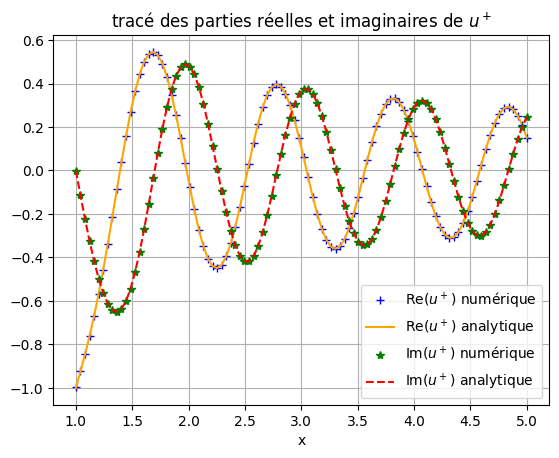

In [11]:
N = 200  # nombre de noeuds (par ex. 12)
Nxi = 100
a = 1.0  # rayon du cercle
k = 2*np.pi
n = 2 # nombre de terme dans la somme pour Gauss-Legendre

theta, nodes = generate_nodes(N, a)
segments = generate_segments_indices(N)

############ u+ calculé avec le solveur BEM ###############

xi = np.linspace(a,a*5,Nxi)
x = [(0,i) for i in xi]

uNum = representationIntegrale(x,N,points,poids,G,segments,nodes,a,k)
uplus = uPlus(a,xi,np.pi/2,k)
        

R1 = np.real(uNum)
R = np.real(uplus)
I1 = np.imag(uNum)
I = np.imag(uplus)

plt.plot(xi,R1, color="blue", label="Re($u^+$) numérique", marker="+", linestyle='None')
plt.plot(xi,R, color="orange", label="Re($u^+$) analytique")
plt.plot(xi,I1, color="green", label="Im($u^+$) numérique", marker="*", linestyle="None")
plt.plot(xi,I, color="red", label="Im($u^+$) analytique", linestyle="--")
plt.title("tracé des parties réelles et imaginaires de $u^+$")

plt.xlabel("x")
plt.legend()
plt.grid()
plt.show()

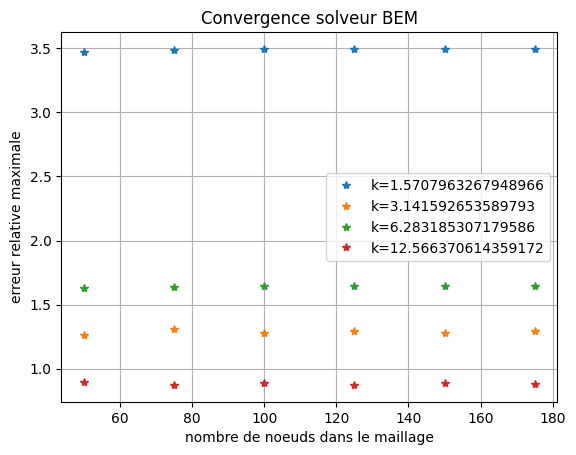

In [12]:
############## erreur relative u+ #################

xi = np.linspace(a,a*5,Nxi)
x = [(0,i) for i in xi]
Nli = np.arange(50,200,25,dtype=int)

for kPara in [np.pi/2,np.pi,np.pi*2,np.pi*4]:
    e = []
    for n in Nli:
        _, nodes = generate_nodes(n, a)
        segments = generate_segments_indices(n)
        uplus = uPlus(a,xi,0,kPara)
        uNum = representationIntegrale(x,n,points,poids,G,segments,nodes,a,kPara)
        E = np.abs((uplus - uNum)/uplus)
        e.append(np.max(E))
    plt.plot(Nli,e, marker="*", linestyle="None", label="k="+str(kPara))

plt.xlabel("nombre de noeuds dans le maillage")
plt.ylabel("erreur relative maximale")
plt.title("Convergence solveur BEM")
plt.legend()
plt.grid()
plt.show()